In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "src"))

In [4]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from copy import deepcopy
import seaborn.objects as so



from variables import get_db_path
from db_commands.connect import connect_to_real_db 
from db_commands.read import read_all_entries, aggregate_focus_project_date


In [4]:
connection = connect_to_real_db(get_db_path())
df = read_all_entries(connection)
df_agg = aggregate_focus_project_date(df)
df_agg

focus_area,project,date,minutes
str,str,str,duration[ms]
"""personal_code""","""time_logger""","""2024-12-05""",2h 19m
"""personal_code""","""slowcial""","""2024-12-18""",1h 47m
"""admin""","""cee243""","""2024-12-14""",3h 17m
"""phd""","""SERC""","""2024-12-13""",32m
"""career""","""building africa's cities summi…","""2024-12-06""",1h 32m
"""personal_code""","""time_logger""","""2024-12-11""",1h 49m
"""career""","""summer24 job application""","""2024-12-13""",3h 39m
"""career""","""summer24 job application""","""2024-12-20""",2h 37m
"""foundations""","""probabilistic graphical models""","""2024-12-18""",1h 30m


In [5]:
df_piv = df_agg.pivot(on="focus_area", values="minutes")
df_piv


project,date,personal_code,admin,phd,career,foundations
str,str,duration[ms],duration[ms],duration[ms],duration[ms],duration[ms]
"""time_logger""","""2024-12-05""",2h 19m,null,null,null,null
"""slowcial""","""2024-12-18""",1h 47m,null,null,null,null
"""cee243""","""2024-12-14""",null,3h 17m,null,null,null
"""SERC""","""2024-12-13""",null,null,32m,null,null
"""building africa's cities summi…","""2024-12-06""",null,null,null,1h 32m,null
"""time_logger""","""2024-12-11""",1h 49m,null,null,null,null
"""summer24 job application""","""2024-12-13""",null,null,null,3h 39m,null
"""summer24 job application""","""2024-12-20""",null,null,null,2h 37m,null
"""probabilistic graphical models""","""2024-12-18""",null,null,null,null,1h 30m


In [59]:
durations = df_piv.select(pl.selectors.duration()).to_pandas()
durations

,personal_code,admin,phd,career,foundations
0,0 days 02:19:00,NaT,NaT,NaT,NaT
1,0 days 01:47:00,NaT,NaT,NaT,NaT
2,NaT,0 days 03:17:00,NaT,NaT,NaT
3,NaT,NaT,0 days 00:32:00,NaT,NaT
4,NaT,NaT,NaT,0 days 01:32:00,NaT
5,0 days 01:49:00,NaT,NaT,NaT,NaT
6,NaT,NaT,NaT,0 days 03:39:00,NaT
7,NaT,NaT,NaT,0 days 02:37:00,NaT
8,NaT,NaT,NaT,NaT,0 days 01:30:00
9,0 days 01:55:00,NaT,NaT,NaT,NaT


In [74]:
hasattr(durations["personal_code"][2], "components")

False

datetime.timedelta(0)

In [87]:
def get_valid_durations(time_data):
    return [i.to_pytimedelta().seconds if hasattr(i, "components") else datetime.timedelta(0).seconds for i in time_data]

In [88]:
for name, time_data in durations.items():
    vals = get_valid_durations(time_data)
    print(vals)
    # print([i.seconds for i in vals])
    # print([i.to_pytimedelta() if hasattr(i, "components") else datetime.timedelta(0) for i in time_data ])

[8340, 6420, 0, 0, 0, 6540, 0, 0, 0, 6900]
[0, 0, 11820, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1920, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 5520, 0, 13140, 9420, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 5400, 0]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 3 with shape (20,).

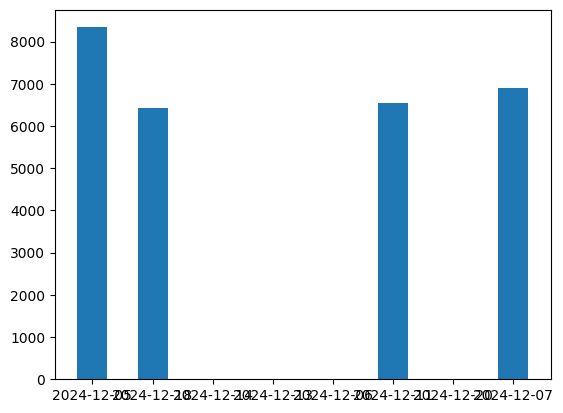

In [89]:
fig, ax = plt.subplots()
bottom = [datetime.timedelta(0).seconds]*10

width = 0.5

dates = df_piv["date"].to_list()

for focus_area, time_data in durations.items():
    times = get_valid_durations(time_data)
    p = ax.bar(dates, times, width, label=focus_area, bottom=bottom)
    bottom+=times

# for boolean, weight_count in weight_counts.items():
#     p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
#     bottom += weight_count

In [7]:
df_agg

focus_area,project,date,minutes
str,str,str,duration[ms]
"""personal_code""","""time_logger""","""2024-12-05""",2h 19m
"""personal_code""","""slowcial""","""2024-12-18""",1h 47m
"""admin""","""cee243""","""2024-12-14""",3h 17m
"""phd""","""SERC""","""2024-12-13""",32m
"""career""","""building africa's cities summi…","""2024-12-06""",1h 32m
"""personal_code""","""time_logger""","""2024-12-11""",1h 49m
"""career""","""summer24 job application""","""2024-12-13""",3h 39m
"""career""","""summer24 job application""","""2024-12-20""",2h 37m
"""foundations""","""probabilistic graphical models""","""2024-12-18""",1h 30m


In [8]:
import plotly.express as px


In [13]:
pl.Duration.to_python()

datetime.timedelta

In [18]:
import datetime

In [19]:
df_plt = df_agg.with_columns(minutes=pl.col("minutes").cast(datetime.timedelta))
df_plt

focus_area,project,date,minutes
str,str,str,duration[μs]
"""personal_code""","""time_logger""","""2024-12-05""",2h 19m
"""personal_code""","""slowcial""","""2024-12-18""",1h 47m
"""admin""","""cee243""","""2024-12-14""",3h 17m
"""phd""","""SERC""","""2024-12-13""",32m
"""career""","""building africa's cities summi…","""2024-12-06""",1h 32m
"""personal_code""","""time_logger""","""2024-12-11""",1h 49m
"""career""","""summer24 job application""","""2024-12-13""",3h 39m
"""career""","""summer24 job application""","""2024-12-20""",2h 37m
"""foundations""","""probabilistic graphical models""","""2024-12-18""",1h 30m


In [29]:
df_pandas = df_plt.to_pandas()
df_pandas["minutes"] = df_pandas["minutes"].dt.to_pytimedelta()
df_pandas

,focus_area,project,date,minutes
0,personal_code,time_logger,2024-12-05,0 days 02:19:00
1,personal_code,slowcial,2024-12-18,0 days 01:47:00
2,admin,cee243,2024-12-14,0 days 03:17:00
3,phd,SERC,2024-12-13,0 days 00:32:00
4,career,building africa's cities summit,2024-12-06,0 days 01:32:00
5,personal_code,time_logger,2024-12-11,0 days 01:49:00
6,career,summer24 job application,2024-12-13,0 days 03:39:00
7,career,summer24 job application,2024-12-20,0 days 02:37:00
8,foundations,probabilistic graphical models,2024-12-18,0 days 01:30:00
9,personal_code,slowcial,2024-12-07,0 days 01:55:00


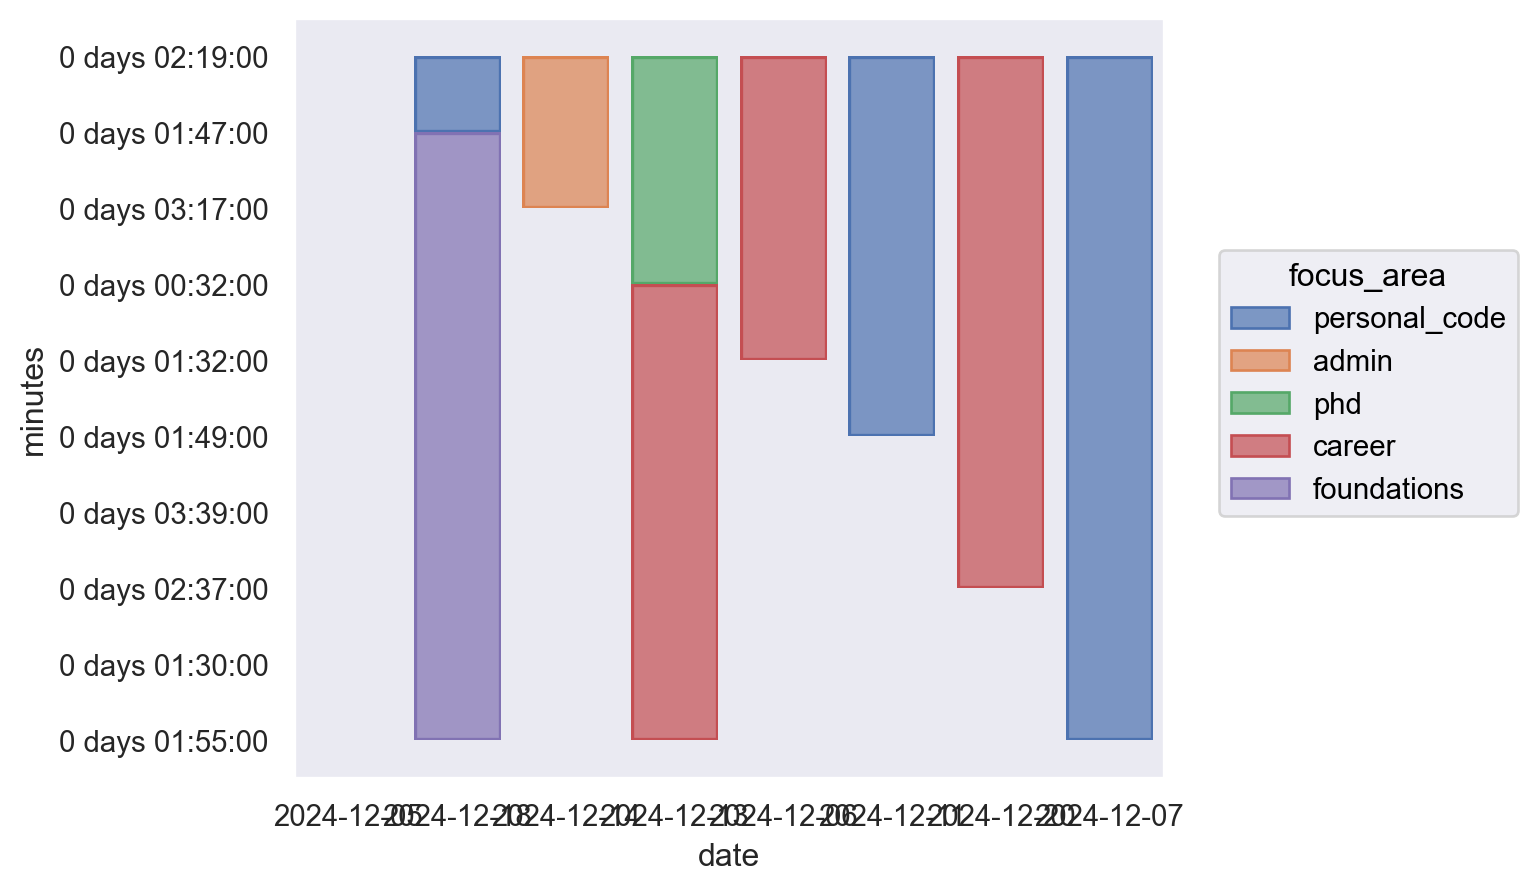

In [35]:
so.Plot(df_pandas, x="date", y="minutes", color="focus_area").add(so.Bar(), so.Stack())

In [31]:
fig = px.bar(df_pandas, x='date', y='minutes', color="focus_area")
fig.update_layout(yaxis_tickformat="%H:%M")
fig.show()

In [31]:
for col in durations.iter_columns():
    print((col.name, col.to_list()))


('personal_code', [datetime.timedelta(seconds=6420), None, None, None, None, datetime.timedelta(seconds=8340), datetime.timedelta(seconds=6900), datetime.timedelta(seconds=6540), None, None])
('career', [None, datetime.timedelta(seconds=13140), None, None, None, None, None, None, datetime.timedelta(seconds=9420), datetime.timedelta(seconds=5520)])
('admin', [None, None, datetime.timedelta(seconds=11820), None, None, None, None, None, None, None])
('phd', [None, None, None, datetime.timedelta(seconds=1920), None, None, None, None, None, None])
('foundations', [None, None, None, None, datetime.timedelta(seconds=5400), None, None, None, None, None])
